## Overview

This is the Jupyter Notebook for my cat breed detector AI.

## 1. Initialization

In [1]:
# Import fastai v2 for computer vision
from fastai.vision.all import *
from fastai.vision.widgets import *

In [2]:
# Check for CUDA & GPU
if torch.cuda.is_available():
    print(f'gpu: {torch.cuda.current_device()} ({torch.cuda.get_device_name()})')

gpu: 0 (GeForce RTX 2070 SUPER)


## 2. Data

In [3]:
# Get path to data
path = untar_data(URLs.PETS)
path.ls()

(#2) [Path('C:/Users/bakti/.fastai/data/oxford-iiit-pet/annotations'),Path('C:/Users/bakti/.fastai/data/oxford-iiit-pet/images')]

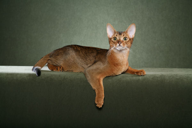

In [4]:
# Check first image
path_to_img = (path/'images').ls()[0]
img = PILImage.create(path_to_img)
img.to_thumb(192)

## 3. Dataloaders

# Some of the below tools were taken from the following shared resource: (see the notebook [07_sizing_and_tta.ipynb](https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb)):
- **Data Augmentation** with the list of transforms at batch level (`aug_transforms()`).
- **Normalization** with the standard ImageNet mean and standard deviation (`Normalize.from_stats(*imagenet_stats)`).
- **Progressive Resizing**: Gradually using larger and larger images as you train (`get_dls()`).

This one was taken from a FastAI lesson 
- **Presizing** (notebook [05_pet_breeds.ipynb](https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb)).

In [5]:
def get_dls(bs, size):
    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items=get_image_files, 
                       splitter=RandomSplitter(seed=42),
                       get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                       item_tfms=Resize(460),
                       batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                                   Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path/"images", bs=bs)

In [6]:
# Get Dataloaders
dls = get_dls(128, 128)

In [7]:
# Check number of categories and list
dls.vocab

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

In [8]:
# Batch size and Check images in training batch
dls.bs, dls.show_batch(nrows=1, ncols=3)

IndexError: list index out of range

## 4. First model 

This is my first model that I predict will have a higher level of accuracy due to machine learning methods used. 

Here are the following techniques I will use for first model
1. **gradual unfreezing** of layers from the last ones to the first ones.
2. **Discriminative Learning Rates** used with CC from this shared notebook [05_pet_breeds.ipynb](https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb)).
3. **Deeper Architectures**: I will start  with resnet34 as baseline, and then resnet152 as final model.

### 4.1 Images of size 128

In [ ]:
# Learner with model resnet34
dls = get_dls(128, 128)
model = resnet34
loss_func=LabelSmoothingCrossEntropy()

learn = cnn_learner(dls, model, loss_func=loss_func, metrics=[accuracy])

#### Freeze all layers but the last (new) ones

In [ ]:
# Check model and frozen layers
learn.freeze()
learn.summary()

In [ ]:
# Learning rate
learn.lr_find()

As only the last layers are unfrozen, **I only want the learning rate to be 10 times less than the one of the loss minimum as lr_max (1e-2)**.

In [ ]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 1e-2
learn.fit_one_cycle(1, lr_max=lr_max)

In [ ]:
# Display the Learning rate and momentum values used in training
learn.recorder.plot_sched()

In [ ]:
# Save the model
learn.save('catbreeds_1')

#### Unfreeze all layers and Discriminative Learning Rates

In [ ]:
# Load model, unfreeze layers and check it
learn = learn.load('catbreeds_1')
learn.unfreeze()
learn.summary()

In [ ]:
# Learning rate
learn.lr_find()

As I unfroze all layers of the model, **let's choose the learning rate of the loss minimum as lr_max (1e-3)**.

In [ ]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 1e-3
lr_min = lr_max / 100
learn.fit_one_cycle(10, lr_max=slice(lr_min,lr_max))

Baseline model accuracy: **89.31%**. This is a very high degree of accuracy for our first model. Let's see if we can improve on it. 

In [ ]:
# Display the training and validation loss
learn.recorder.plot_loss()

In [ ]:
# Save the model
learn.save('catbreeds_2')

### 4.2 Images of size 224

In [ ]:
# Learner with model resnet34
dls = get_dls(64, 224)
model = resnet34
loss_func=LabelSmoothingCrossEntropy()

learn = cnn_learner(dls, model, loss_func=loss_func, metrics=[accuracy])
learn = learn.load('catbreeds_2')

#### Freeze all layers but the last (new) ones

In [ ]:
# Learning rate
learn.freeze()
learn.lr_find()

As only the last layers are unfrozen, **I once again choose the learning rate 10 times less than the one of the loss minimum as lr_max (2e-4)**.

In [ ]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 2e-4
learn.fit_one_cycle(1, lr_max=lr_max)

In [ ]:
# Save the model
learn.save('catbreeds_3')

#### Unfreeze all layers and Discriminative Learning Rates

In [ ]:
# Load model, unfreeze layers and check it
learn = learn.load('catbreeds_3')
learn.unfreeze()

In [ ]:
# Learning rate
learn.lr_find()

As we unfroze all layers of the model, **let's choose the learning rate of the loss minimum as lr_max (2e-4)**.

In [ ]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 2e-4
lr_min = lr_max / 100
learn.fit_one_cycle(10, lr_max=slice(lr_min,lr_max))

In [ ]:
# Test Time Augmentation
# notebook: https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb
learn.epoch = 0
preds,targs = learn.tta()
accuracy(preds, targs).item()

Baseline model accuracy: **95.40%**. This is the very high degree of accuracy that I was looking for.

In [ ]:
# Display the training and validation loss
learn.recorder.plot_loss()

In [ ]:
# Save the model
learn.save('catbreeds_4')

## 5. Results analysis

In [ ]:
# Load model and display the Confusion Matrix
learn = learn.load('catbreeds_4')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
# Get categories with the most errors
interp.most_confused(min_val=3)

In [ ]:
# Get the images with highest loss between prediction and true category
interp.plot_top_losses(5, nrows=1)

In [ ]:
# Clean training and validation datasets
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## 6. Deeper model

### 6.1 Images of size 128

In [ ]:
# Learner with model resnet152
dls = get_dls(128, 128)
model = resnet152
loss_func=LabelSmoothingCrossEntropy()

learn = cnn_learner(dls, model, loss_func=loss_func, metrics=[accuracy])

#### Freeze all layers but the last (new) ones

In [ ]:
# Check model and frozen layers
learn.freeze()

In [ ]:
# Learning rate
learn.lr_find()

As only the last layers are unfrozen, **the learning rate 10 times less than the one of the loss minimum as lr_max (1e-2)**.

In [ ]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 1e-2
learn.fit_one_cycle(1, lr_max=lr_max)

In [ ]:
# Save the model
learn.save('catbreeds_5')

#### Unfreeze all layers and Discriminative Learning Rates

In [ ]:
# Load model, unfreeze layers and check it
learn = learn.load('catbreeds_5')
learn.unfreeze()

In [ ]:
# Learning rate
learn.lr_find()

As we unfroze all layers of the model, **let's choose the learning rate of the loss minimum as lr_max (2e-4)**.

In [ ]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 2e-4
lr_min = lr_max / 100
learn.fit_one_cycle(10, lr_max=slice(lr_min,lr_max))

Deeper model accuracy: **89.78%**

In [ ]:
# Display the training and validation loss
learn.recorder.plot_loss()

In [ ]:
# Save the model
learn.save('catbreeds_6')

### 6.2 Images of size 224

In [ ]:
# Learner with model resnet152
dls = get_dls(64, 224)
model = resnet152
loss_func=LabelSmoothingCrossEntropy()

learn = cnn_learner(dls, model, loss_func=loss_func, metrics=[accuracy])
learn = learn.load('catbreeds_6')

#### Freeze all layers but the last (new) ones

In [ ]:
# Learning rate
learn.freeze()
learn.lr_find()

As only the last layers are unfrozen, **let's choose the learning rate 10 times less than the one of the loss minimum as lr_max (1e-3)**.

In [ ]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 1e-3
learn.fit_one_cycle(1, lr_max=lr_max)

In [ ]:
# Save the model
learn.save('catbreeds_7')

#### Unfreeze all layers and Discriminative Learning Rates

In [ ]:
# Load model, unfreeze layers and check it
learn = learn.load('catbreeds_7')
learn.unfreeze()

In [ ]:
# Learning rate
learn.lr_find()

As we unfroze all layers of the model, **let's choose the learning rate of the loss minimum as lr_max (2e-5)**.

In [ ]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 2e-5
lr_min = lr_max / 100
learn.fit_one_cycle(10, lr_max=slice(lr_min,lr_max))

In [ ]:
# Test Time Augmentation
# notebook: https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb
learn.epoch = 0
preds,targs = learn.tta()
accuracy(preds, targs).item()

Deeper model accuracy: **94.92%**. Whilst this is pretty high, the accuracy of our first model is still slightly higher at  95.4%. 



In [ ]:
# Display the training and validation loss
learn.recorder.plot_loss()

In [ ]:
# Save the model
learn.save('catbreeds_8')

## 7. Deeper model with regularisation

In [ ]:
# Learner with model resnet152
dls = get_dls(64, 224)
model = resnet152
loss_func=LabelSmoothingCrossEntropy()

learn = cnn_learner(dls, model, loss_func=loss_func, metrics=[accuracy])
learn = learn.load('catbreeds_7')

### Dropout

In [ ]:
# The model has already a value of 50% of dropout
learn.model[1][7]

### Weight Decay

In [ ]:
# Load model, unfreeze layers and check it
learn.unfreeze()
learn.opt_func

In [ ]:
#  increase weight decay from 0.01 to 0.1
wd = 0.1
learn.opt_func = partial(Adam, sqr_mom=0.99, eps=1e-05, wd=wd, decouple_wd=True)
learn.opt_func

In [ ]:
# Learning rate
learn.lr_find()

As we unfroze all layers of the model, **we choose the learning rate of the loss minimum as lr_max (2e-5)**.

In [ ]:
# Train the model with lr_max and the fit_one_cycle() function on 1 epoch
lr_max = 2e-5
lr_min = lr_max / 100
learn.fit_one_cycle(10, lr_max=slice(lr_min,lr_max))

In [ ]:
# Test Time Augmentation
# notebook: https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb
learn.epoch = 0
preds,targs = learn.tta()
accuracy(preds, targs).item()

The accuracy did not improve. **The only way for this AI to improve is to get more training data. 

In [ ]:
# Display the training and validation loss
learn.recorder.plot_loss()

In [ ]:
# Save the model
learn.save('catbreeds_9')

## 8. Export best model

According to the accuracy, **we keep our first model as the best one with a validation accuracy of 95.4%**.

In [ ]:
# Export best model
learn = learn.load('catbreeds_4')
learn.export()

In [ ]:
# Get model for inference
learn_inf = load_learner ( 'export.pkl' )

In [ ]:
# Button to upload image
btn_upload = widgets . FileUpload ()
# Button to classify
btn_run = widgets . Button ( description = 'Classify' )
# Display a thumb of the image
out_pl = widgets . Output ()
out_pl . clear_output ()
# Calculation and display of the category prediction
lbl_pred = widgets . Label ()
def on_click_classify ( change ):
img = PILImage . create ( btn_upload . data [ - 1 ])
out_pl . clear_output ()
with out_pl : display ( img . to_thumb ( 128 , 128 ))
pred , pred_idx , probs = learn_inf . predict ( img )
lbl_pred . value = f 'Prediction: { pred } ; Probability: { probs [ pred_idx ] : .04f } '
btn_run . on_click ( on_click_classify )

In [ ]:
# Run app
VBox ([ widgets . Label ( 'Select your animal!' ),
btn_upload , btn_run , out_pl , lbl_pred ])